## TOM.ipynb


### Preliminaries

This code builds a simple timing strategy around the turn of the month.


- We use the data `DailyMktData.parquet`. 


In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import qpm_download
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt 
import matplotlib.pylab as pylab
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.iolib.summary2 import summary_col

from matplotlib import rcParams

DataFrame = pd.DataFrame
Series = pd.Series
pd.options.mode.chained_assignment = None

rcParams['font.family'] = 'sans serif'
rcParams['font.serif'] = ['Helvetica']

params = {'font.size' : 16}
pylab.rcParams.update(params)

Here we specify whether we would like to download the data and the directory in which the data is stored.

In [2]:
import_data = False
_DATA_DIR = '/Users/jiahongcai/Desktop/Quantitative Strategies/Data'

### Step 1. Load Data

We will load the market excess returns:

In [3]:
print('> Loading Market Excess Returns...')

if import_data == True:
    
    df_rets = qpm_download.FFdaily('1963-07-01','2023-07-31')

if import_data == False:
    
    # Load the data
    df_rets = pd.read_parquet('%s/DailyMktData.parquet' %(_DATA_DIR))
    
print(df_rets.head(5))

> Loading Market Excess Returns...
        date   mktrf     smb     hml       rf     umd     rmw     cma  \
0 1963-07-01 -0.0067  0.0002 -0.0035  0.00012 -0.0021  0.0003  0.0013   
1 1963-07-02  0.0079 -0.0028  0.0028  0.00012  0.0042 -0.0008 -0.0021   
2 1963-07-03  0.0063 -0.0018 -0.0010  0.00012  0.0041  0.0013 -0.0025   
3 1963-07-05  0.0040  0.0009 -0.0028  0.00012  0.0007  0.0007 -0.0030   
4 1963-07-08 -0.0063  0.0007 -0.0020  0.00012 -0.0045 -0.0027  0.0006   

          ym  
0 1963-07-01  
1 1963-07-01  
2 1963-07-01  
3 1963-07-01  
4 1963-07-01  


and subset to the relevant time period for our analysis:

In [4]:
df = df_rets[df_rets['ym'] >= '1980-01-01']

### Step 2. Create Weights

In [5]:
# We first sort the data by date
df.sort_values(by = ['ym' ,'date'], inplace = True)

# We calculate the trading day of the month for a given observation
df['day_of_month'] = df.groupby('ym').cumcount()

# We check whether a trading day is the last trading day of the month
df['last_day_of_month'] = (df.groupby('ym')['day_of_month'].transform(max) == df['day_of_month'])

# We invest 500% when it is the last trading day of the month or one of the first three trading days of the month, and 0% otherwise
df['weight'] = df.apply(lambda x : 5 if (x['last_day_of_month'] == True) | (x['day_of_month'] <= 2)  else 0, axis = 1)

# We print the results
df.head(30)

,date,mktrf,smb,hml,rf,umd,rmw,cma,ym,day_of_month,last_day_of_month,weight
4136,1980-01-02,-0.0205,0.0019,0.0108,0.00036,-0.0130,-0.0107,0.0080,1980-01-01,0,False,5
4137,1980-01-03,-0.0073,-0.0088,0.0033,0.00036,-0.0072,-0.0028,0.0016,1980-01-01,1,False,5
4138,1980-01-04,0.0132,0.0062,-0.0040,0.00036,0.0062,-0.0013,-0.0059,1980-01-01,2,False,5
4139,1980-01-07,0.0039,0.0026,0.0004,0.00036,0.0038,-0.0045,0.0003,1980-01-01,3,False,0
4140,1980-01-08,0.0192,-0.0032,-0.0069,0.00036,0.0004,0.0067,-0.0038,1980-01-01,4,False,0
4141,1980-01-09,0.0011,0.0063,0.0000,0.00036,0.0024,0.0019,-0.0049,1980-01-01,5,False,0
4142,1980-01-10,0.0085,0.0036,-0.0005,0.00036,0.0013,0.0004,-0.0004,1980-01-01,6,False,0
4143,1980-01-11,0.0020,0.0026,0.0045,0.00036,0.0040,-0.0049,-0.0001,1980-01-01,7,False,0
4144,1980-01-14,0.0034,0.0037,0.0065,0.00036,0.0045,-0.0066,0.0073,1980-01-01,8,False,0
4145,1980-01-15,0.0054,-0.0014,-0.0012,0.00036,0.0018,0.0013,0.0015,1980-01-01,9,False,0


### Step 3. Compute Excess Portfolio Returns

In [6]:
# Compute the excess return on the portfolio
df['mktrf_p'] = df['weight'] * df['mktrf']
df.head(5)

,date,mktrf,smb,hml,rf,umd,rmw,cma,ym,day_of_month,last_day_of_month,weight,mktrf_p
4136,1980-01-02,-0.0205,0.0019,0.0108,0.00036,-0.0130,-0.0107,0.0080,1980-01-01,0,False,5,-0.1025
4137,1980-01-03,-0.0073,-0.0088,0.0033,0.00036,-0.0072,-0.0028,0.0016,1980-01-01,1,False,5,-0.0365
4138,1980-01-04,0.0132,0.0062,-0.0040,0.00036,0.0062,-0.0013,-0.0059,1980-01-01,2,False,5,0.0660
4139,1980-01-07,0.0039,0.0026,0.0004,0.00036,0.0038,-0.0045,0.0003,1980-01-01,3,False,0,0.0000
4140,1980-01-08,0.0192,-0.0032,-0.0069,0.00036,0.0004,0.0067,-0.0038,1980-01-01,4,False,0,0.0000


### Step 4. Portfolio Analytics

We first plot the cumulative return

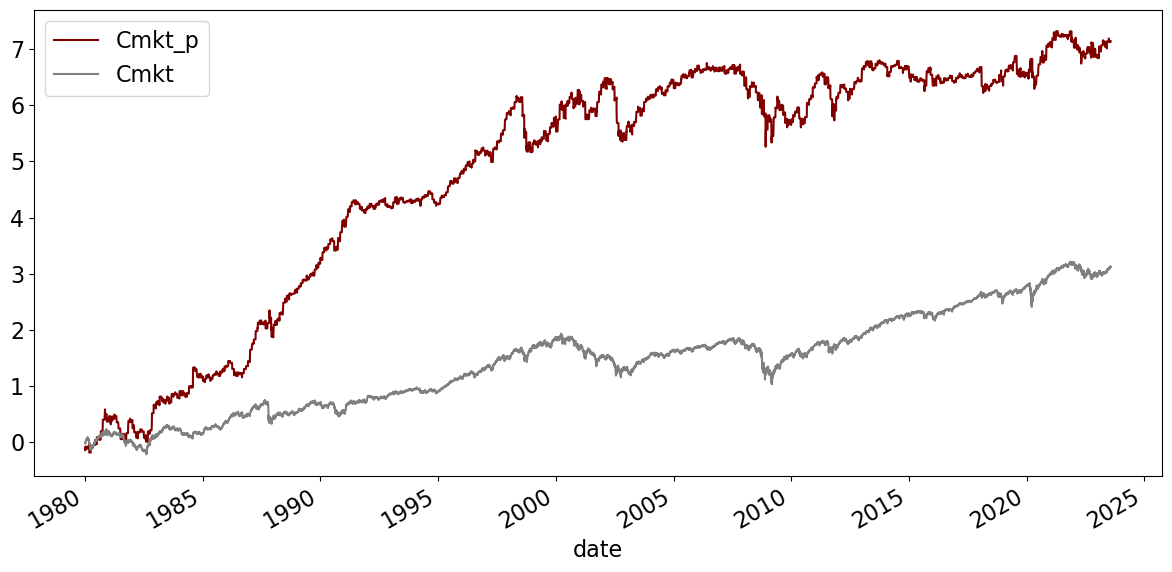

In [7]:
fig = plt.figure(figsize = (12, 6))

df['Cmkt'] = np.log(1 + df['mktrf']).cumsum()
df['Cmkt_p'] = np.log(1 + df['mktrf_p']).cumsum()

df[['Cmkt_p', 'Cmkt','date']].set_index('date').plot(color = ['maroon', 'gray'], ax = plt.gca())
fig.tight_layout()
plt.show()
plt.close()

We conclude by regressing the excess return on the strategy on the excess return on the market.

In [8]:
reg_df = df[['mktrf_p', 'mktrf']].dropna()
reg_results = smf.ols(formula='mktrf_p ~ mktrf', data=reg_df).fit()
print(summary_col(reg_results, stars=True)) 


                mktrf_p 
------------------------
Intercept      0.0006***
               (0.0002) 
mktrf          0.9048***
               (0.0184) 
R-squared      0.1807   
R-squared Adj. 0.1806   
Standard errors in
parentheses.
* p<.1, ** p<.05,
***p<.01


To simplify the interpretation, we annualize the alpha:

In [9]:
print((reg_results.params['Intercept'] * 252 * 100).round(2))

15.68
